# The Quantum Volume Protocol

Quantum Volume (QV) is a single-number metric to benchmark the performance of QPUs. The QV method quantifies the largest random circuit of equal width and depth $d$ that the QPU successfully implements. The circuit that are run to determine the QV are given by the following structure:

<img src="docs/qv.png" alt="qv" width="600"/>

The QV model circuit has $d$ qubits and consists of $d$ layers. Each layer consists of a random permutation $\pi$ and random $SU(4)$ gates (random $4\times4$ unitaries). The permutation $\pi$ ensures that the qubits interact with new qubits. The $SU(4)$ gates are chosen uniformly at random using the [Haar measure](https://en.wikipedia.org/wiki/Haar_measure) to ensure that the circuit is unbiased.

A QPU has a QV of $2^d$ if it is able to *successfully implement* the QV-circuit of depth $d$.

## Heavy Output Generation Problem (Success Criterion)

Whether a noisy QPU is successful in implementing a circuit is determined by the **heavy output generation problem**. The heavy output generation problem is defined as follows:

Let $p(x) = \langle x | U | 0 \rangle$ be the probabilities of measuring the bit strings $x$ from a QV unitary U. Now we define the heavy output set as $H_U = \{x | p(x) \geq p_{median}\}$, where $p_{median}$ is the median probability.

The problem of generating a heavy output is to generate a sample result $p'(x)$ with a noisy QPU such that at least $2/3$ of the samples come from the heavy output set $H_U$. We denote the probability that a heavy output of a QV circuit U is sampled as the **heavy output probability** (HOP) $p_H$.

If a QPU can successfully generate a sufficient HOP, then it is said to be a QV of the corresponding circuit size.


In [1]:
from rb.quantum_volume import calculate_heavy_output, calculate_heavy_output_probability

# let's say, a QV produces the following distribution
probs = {"00": 0.4, "01": 0.1, "10": 0.2, "11": 0.3}

# We calculate the heavy output set, which are all outputs with a probability greater than the meadian
H_u = calculate_heavy_output(probs)
print("Heavy output set: ", H_u)

# Now, we can calculate the heavy output probability (HOP) for noisy distributions,
# that we might have obtained from a run on a real QPU
noisy_probs1 = {"00": 0.3, "01": 0.2, "10": 0.0, "11": 0.5}
noisy_probs2 = {"00": 0.1, "01": 0.1, "10": 0.8, "11": 0.0}

hop1 = calculate_heavy_output_probability(probs, noisy_probs1)
hop2 = calculate_heavy_output_probability(probs, noisy_probs2)

# We can check if the noisy probabilities are successful in the heavy output generation problem.
hop1_success = hop1 > 2 / 3
hop2_success = hop2 > 2 / 3

print("HOP1: ", hop1, "Success: ", hop1_success)
print("HOP2: ", hop2, "Success: ", hop2_success)

Heavy output set:  {'00', '11'}
HOP1:  0.8 Success:  True
HOP2:  0.1 Success:  False


## Confidence
To check whether a QPU has a QV of $2^d$, we need to be sure that the QPU can produce a heavy output with a probability of at least $2/3$, so that it didn't happen by "accident". To do this, we run the QV circuit of size $d$ in a large number of $n$ trials and perform a confidence interval test for the HOP. For the QV protocol, we use a confidence interval of $97.5\%$.

Since the performance of a QV experiment is binomially distributed (with a certain probability of success $p_H$), we can approximate the binomial distribution for a sufficiently large number of trials $n$ by a normal distribution.
The standard deviation of the normal distribution is given by $\sigma = \sqrt{p_{mean} (1-p_{mean}) / n}$, where $p_{mean}$ is the average HOP of the trials.

To obtain a confidence interval of $97.5\%$, we need to check whether $p_{mean} \geq 2/3 + 2\sigma$, i.e. whether the average HOP is *at least 2 standard deviations greater* than our success criterion of $2/3$.

## Running a Quantum Volume experiment

Let's look at an example of running actual QV circuits and checking whether the QPU has a QV of $2^d$.

In [2]:
from qiskit.providers.fake_provider import FakeHanoiV2
from qiskit_aer import AerSimulator
from rb.quantum_volume import run_qv_experiment, is_successful


hanoi_qpu = FakeHanoiV2()
d = 4

# let's run 200 trials of a QV circuits with d qubits
hops = run_qv_experiment(hanoi_qpu, num_qubits=d, num_trials=200)
print("HOPs: ", hops[:5], "...")

# We can check if the noisy probabilities are confident in the heavy output generation problem.
success = is_successful(hops)
print(f"Successful QV = {2**d}?", "Yes" if success else "No")

HOPs:  [0.69 0.68 0.76 0.7  0.85] ...
Successful QV = 16? Yes


To look at this in more detail, we can also plot a QV experiment as follows:

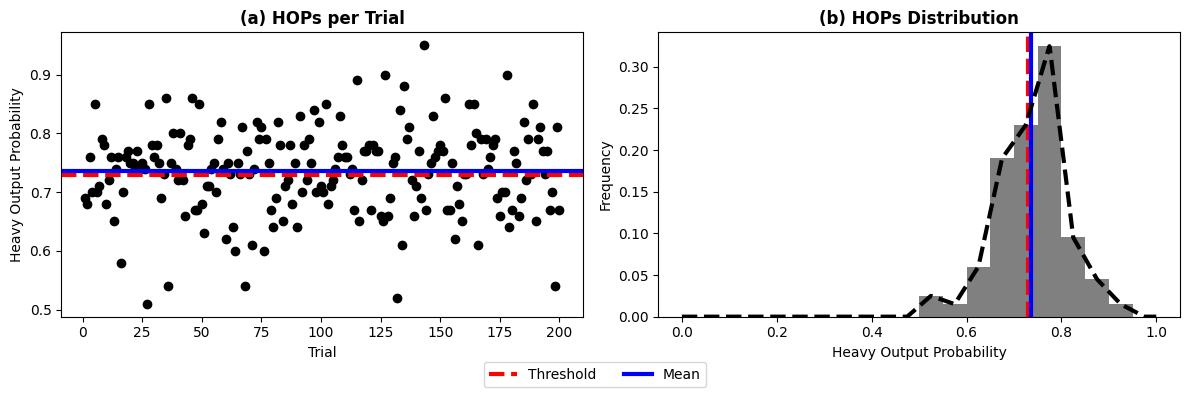

In [3]:
from rb.quantum_volume import plot_qv_experiment

fig = plot_qv_experiment(hops)
fig;

In the left plot, we show the HOP of the individual trials. In the right plot, we show the probability distribution over the HOPs, which has the form of a normal distribution. In both graphs, the red line shows the success threshold of $2/3 + 2 \sigma$, and the blue line shows the average HOP of the trials.

A QV experiment is considered *successful* if the average HOP (blue) is greater than the success threshold (red).

To show how a failing QV experiment looks like, let's run the following QV experiment:

HOPs:  [0.41 0.62 0.47 0.61 0.43] ...
Successful QV = 64? No


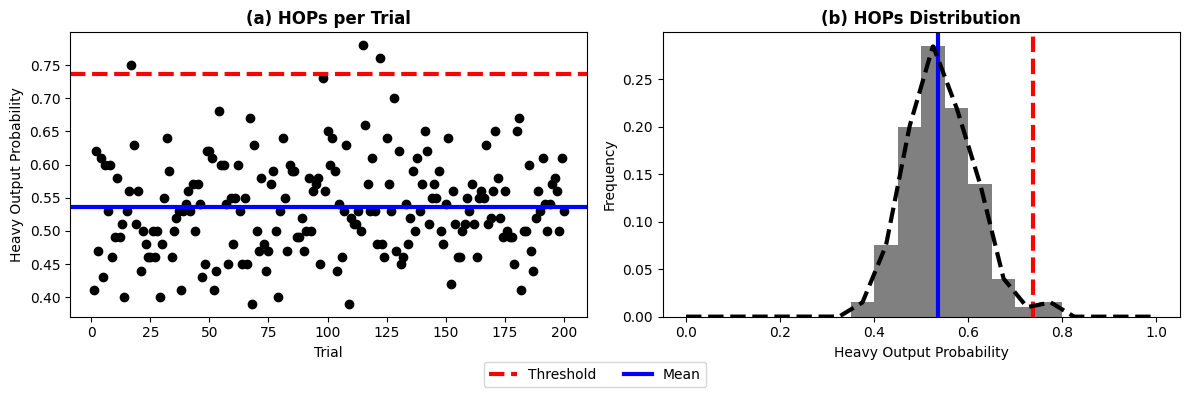

: 

In [ ]:
d = 6

# let's run 200 trials of a QV circuits with d qubits
hops = run_qv_experiment(noisy_qpu, num_qubits=d, num_trials=200)
print("HOPs: ", hops[:5], "...")

# We can check if the noisy probabilities are confident in the heavy output generation problem.
success = is_successful(hops)
print(f"Successful QV = {2**d}?", "Yes" if success else "No")

fig = plot_qv_experiment(hops)
fig;

We clearly see that the average HOP is below the success threshold, and the QPU does **not** have a QV of $2^d$.

## Running the Quantum Volume Protocol

Finally, lets put everything together and run the QV protocol which finds the QV of a QPU.
For the QV protocol, we perform a binary search to find the largest circuit size $d$ which the QPU can successfully implement. The QPU then has a QV of $2^d$.

In [ ]:
from rb.quantum_volume import find_quantum_volume

# run a binary search to find the largest QV circuit that can be run successfully
d = find_quantum_volume(noisy_qpu, num_trials=200)
print("QV: ", d)

-------
Trying for QV 8...
✅
-------
Trying for QV 32...
❌
-------
Trying for QV 16...
✅
QV: 16 🎉
QV:  16


: 

### Benchmarking QPUs using Quantum Volume

Finally, let's use the quantum volume protocol to benchmark and compare different QPUs:

For this, let's use the following QPUs:
- IBMQ Oslo
- IBMQ Kolkata
- IBMQ Sherbrooke
- IonQ Aria

In [ ]:
from qiskit.providers import BackendV2
from qiskit.providers.fake_provider import FakeOslo, FakeKolkataV2, FakeSherbrooke

oslo = FakeOslo()
kolkata = FakeKolkataV2()
sherbrooke = FakeSherbrooke()

qpus: list[BackendV2] = [oslo, kolkata, sherbrooke]

highest_qv = 0, ""
for qpu in qpus:
    print("---------------------")
    print(f"Backend: {qpu.name()}")
    qv = find_quantum_volume(qpu, num_trials=200)
    highest_qv = max(highest_qv, (qv, qpu.name()))

print("---------------------")
print("Highest QV: ", highest_qv[0], "Backend: ", highest_qv[1])

---------------------
Backend: oslo
-------
Trying for QV 8...
✅
-------
Trying for QV 32...
❌
-------
Trying for QV 16...
✅
QV: 16 🎉
---------------------
Backend: kolkata
-------
Trying for QV 8...
✅
-------
Trying for QV 32...
❌
-------
Trying for QV 16...
✅
QV: 16 🎉
---------------------
Backend: sherbrooke
-------
Trying for QV 8...
✅
-------
Trying for QV 32...
❌
-------
Trying for QV 16...
✅
QV: 16 🎉
---------------------
Backend: ionq
-------
Trying for QV 8...
✅
-------
Trying for QV 32...
✅
QV: 32 🎉
---------------------
Highest QV:  32 Backend:  ionq


: 

: 